### Watertight STL to Node Converter
Convert tetrahedral meshes in stl format into [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/) node representation using the [Trimesh](https://trimesh.org/) library. The converter does not work on non-watertight surfaces, i.e. raw_cloud and raw_norm

In [13]:
import os
import glob
import torch
from torch_geometric.data import Data
import trimesh
import trimesh
import pyvista as pv
from torch_geometric.data import DataLoader
import numpy as np

#### View Watertight STLs using Trimesh

In [14]:
# TODO: Try non-watertight google drive repository, add interior visualization 
mesh_path = "../../data/fulldata/parts_0/parts_0_files_1_to_3950_rotated_stl_files/0a0b5e6b-734a-40b4-9fa2-d6bff769868a.stl"
mesh_trimesh = trimesh.load(mesh_path, file_type='stl')

In [16]:
vertices = mesh_trimesh.vertices
faces = mesh_trimesh.faces
faces_pv = np.hstack([np.full((faces.shape[0], 1), 3), faces]).flatten()
mesh_pv = pv.PolyData(vertices, faces_pv)

/Users/mihir/miniconda3/lib/python3.12/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


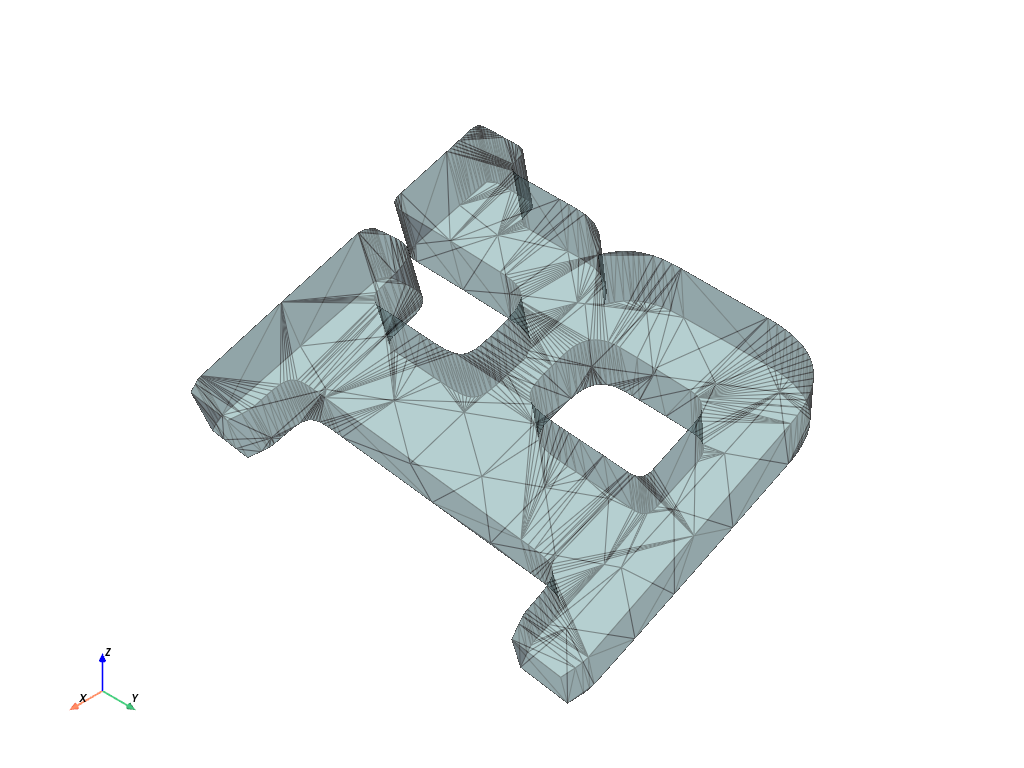

In [18]:
plotter = pv.Plotter()
plotter.add_mesh(mesh_pv, color='lightblue', opacity=0.5, show_edges=True)
plotter.add_axes()
plotter.show()

#### Build Graph Tensor

In [7]:
# TODO: Store filenames with graph representation for easy viewing later
def stl_to_graph(file_path):
    # Load the mesh
    mesh = trimesh.load_mesh(file_path)
    
    # Extract vertices and faces
    vertices = mesh.vertices  # NumPy array of shape (num_vertices, 3)
    faces = mesh.faces  # NumPy array of shape (num_faces, 3)
    
    # Convert vertices to tensor
    x = torch.tensor(vertices, dtype=torch.float)
    
    # Build edge_index from faces
    edge_index = build_edge_index(faces)
    
    # Create graph data object
    data = Data(x=x, edge_index=edge_index)
    return data

def build_edge_index(faces):
    # Extract edges from faces
    edges = []
    for face in faces:
        v1, v2, v3 = face
        # Add edges (both directions for undirected graphs)
        edges.extend([[v1, v2], [v2, v1],
                      [v2, v3], [v3, v2],
                      [v3, v1], [v1, v3]])
    # Convert to tensor and remove duplicate edges
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    edge_index = torch.unique(edge_index, dim=1)
    return edge_index

#### Generate Graphs per STL

In [ ]:
import json

with open('../data/raw/sanitized_dict.json', 'r') as f:
    quality_scores = json.load(f)

# Convert string quality scores to floats
for key in quality_scores:
    quality_scores[key] = float(quality_scores[key])

In [14]:
import os

def standardize_filename(file_path):
    return os.path.basename(file_path)

quality_scores_standardized = {
    standardize_filename(k): v for k, v in quality_scores.items()
}

In [ ]:
import glob

# Paths
stl_files_directory = '../data/raw/repaired_files/'
stl_files = glob.glob(os.path.join(stl_files_directory, '*.stl'))

dataset = []
missing_scores = []

for file_path in stl_files:
    filename = standardize_filename(file_path)
    if filename in quality_scores_standardized:
        quality_score = quality_scores_standardized[filename]
        try:
            # Convert STL to graph
            graph = stl_to_graph(file_path)
            # Add the quality score as the target label
            graph.y = torch.tensor([quality_score], dtype=torch.float)
            # Append to the dataset
            dataset.append(graph)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    else:
        print(f"No quality score for {file_path}")
        missing_scores.append(file_path)

In [22]:
# View Data Properties
if len(dataset) > 0:
    graph = dataset[100]
    print(graph)
else:
    print("Dataset is empty.")

Data(x=[12, 3], edge_index=[2, 60], y=[1])


In [ ]:
import json

# Load the quality scores from the JSON file
json_file_path = "quality_scores.json"
with open(json_file_path, "r") as f:
    quality_scores = json.load(f)


#### Save

In [ ]:
torch.save(dataset, '../data/processed/repaired_graph_dataset.pt')